[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/burgers_equation/burgers_equation.ipynb)

Solution to the Burgers equation using MPDATA compared against analytic results   
(students' project by: Wojciech Neuman, Paulina Pojda, Michał Szczygieł, Joanna Wójcicka & Antoni Zięciak)

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
from functools import partial
from open_atmos_jupyter_utils import show_anim
from PyMPDATA_examples.burgers_equation import (
    calculate_analytical_solutions,
    run_numerical_simulation,
    plot_analytical_solutions,
    plot_numerical_vs_analytical,
    plot_gif,
    T_RANGE, NT, NX, T_MAX, T_SHOCK,
)

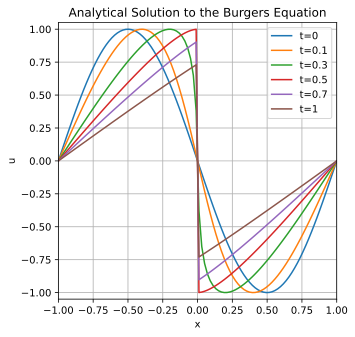

In [3]:
analytical_solutions = calculate_analytical_solutions()
plot_analytical_solutions(analytical_solutions, T_RANGE)

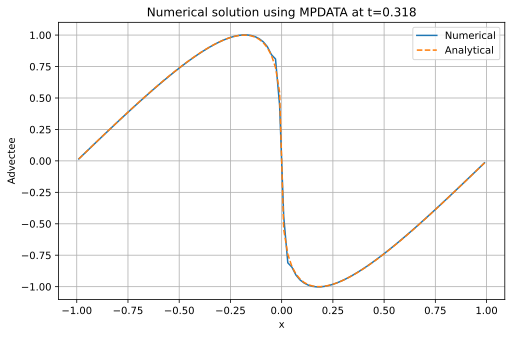

In [4]:
states_num, x_num, dt_num, dx_num = run_numerical_simulation(nt=NT, nx=NX, t_max=T_MAX)
plot_numerical_vs_analytical(states_num, x_num, T_SHOCK, T_MAX, NT)
plot_partial = partial(plot_gif, states=states_num, x=x_num, dt=dt_num)


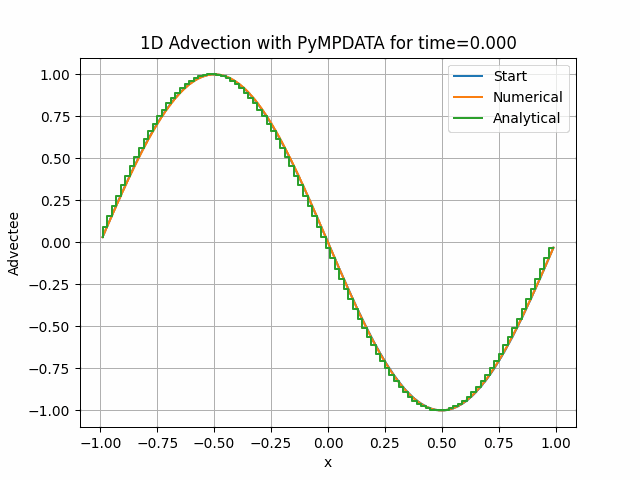

HTML(value="<a href='./numerical.gif' target='_blank'>./numerical.gif</a><br>")

In [5]:
show_anim(plot_partial, range(0, int(T_SHOCK/(T_MAX/NT))), gif_file="numerical.gif")